### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk

nltk.download('wordnet')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
print(project_root)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


c:\Users\user\Desktop\Project\complaint-chatbot


[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import importlib.util
import sys
import os
module_path = r'C:\Users\user\Desktop\Project\complaint-chatbot\src\data_processing.py'
spec = importlib.util.spec_from_file_location(
    "data_processing",
    module_path
)
data_processing = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_processing)

load_data = data_processing.load_data

### load data

In [3]:

df = load_data(r"C:\Users\user\Desktop\Project\complaint-chatbot\data\raw\complaints.csv")

C:\Users\user\Desktop\Project\complaint-chatbot\src\data_processing.py:16: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [4]:
# initial row data
print(df.head())

  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt not owed   
2         Credit reporting           Improper use of your report   
3         Credit reporting           Improper use of your report   
4         Credit reporting  Incorrect information on your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else                          NaN   
1       

In [5]:
# Count explicit NaNs (if any)
print(f"NaN count: {df['Consumer complaint narrative'].isnull().sum()}")
# Count empty strings (often more common in text data)
print(f"Empty string count: {(df['Consumer complaint narrative'] == '').sum()}")

NaN count: 6629041
Empty string count: 0


In [6]:
# --- EDA: Distribution of Products ---
print(df['Product'].value_counts())

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [7]:
# --- EDA: Calculate and visualize word count (simple for demo) ---
df['word_count'] = df['Consumer complaint narrative'].apply(lambda x: len(str(x).split()) if str(x).strip() else 0)
print("\n--- EDA: Word Count Distribution ---")
print(df['word_count'].describe())


--- EDA: Word Count Distribution ---
count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: word_count, dtype: float64


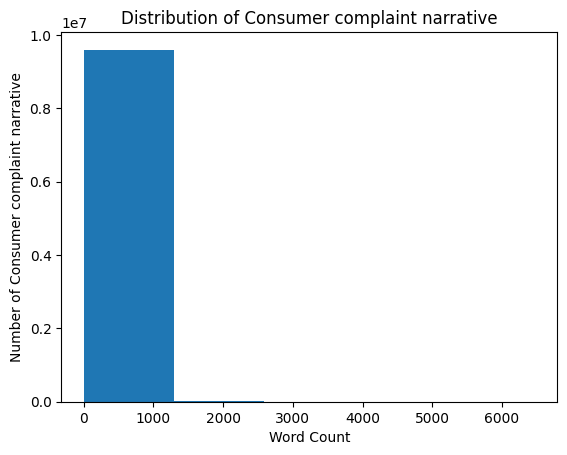

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['word_count'], bins=5)
plt.title('Distribution of Consumer complaint narrative')
plt.xlabel('Word Count')
plt.ylabel('Number of Consumer complaint narrative')
plt.show()

In [9]:

df_cleaned = df[df['Consumer complaint narrative'].str.strip() != ''].copy()
print(f"Original rows: {len(df)}, Rows after removing empty: {len(df_cleaned)}")
print(df_cleaned[['Complaint ID', 'Consumer complaint narrative']])

Original rows: 9609797, Rows after removing empty: 9609797
         Complaint ID Consumer complaint narrative
0            14195687                          NaN
1            14195688                          NaN
2            14195689                          NaN
3            14195690                          NaN
4            14195692                          NaN
...               ...                          ...
9609792       2102374                          NaN
9609793       5637858                          NaN
9609794       2012835                          NaN
9609795        740118                          NaN
9609796       1110751                          NaN

[9609797 rows x 2 columns]


In [10]:
# --- Preprocessing Step 2: Cleaning Text (HTML, URLs, Special Chars, PII) ---
import re

def clean_text_noise(text):
    text = str(text).lower()
    
    # STEP 1: Remove URLs first
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # STEP 2: Remove Phone Numbers (while the digits are still grouped)
    # This pattern looks for 7 to 10 digits in a row
    text = re.sub(r'\b\d{3}[-.\s]?\d{4}\b', '', text) # 7 digit format
    text = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', '', text) # 10 digit format
    text = re.sub(r'\b[A-Z]{2}\d{10,}\b', '', text, flags=re.I)   # Simple IBAN/IDs
    # STEP 3: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # STEP 4: remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    return text.strip()

# Apply the refined cleaning
df_cleaned['processed_Consumer complaint narrative'] = df_cleaned['Consumer complaint narrative'].apply(clean_text_noise)
# # EDA Check: Length of cleaned text
# df['clean_length'] = df['processed_Consumer complaint narrative'].apply(lambda x: len(x.split()))

# # Filter out rows that are now empty or too short
# df_cleaned = df[df['clean_length'] > 2]

print(df_cleaned[['Consumer complaint narrative', 'processed_Consumer complaint narrative']].head())


  Consumer complaint narrative processed_Consumer complaint narrative
0                          NaN                                    nan
1                          NaN                                    nan
2                          NaN                                    nan
3                          NaN                                    nan
4                          NaN                                    nan


In [11]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')  
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# --- Preprocessing Step 3: Tokenization, Stopword Removal, Lemmatization ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = word_tokenize(text)
    
    # 1. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    # 2. Apply Lemmatization for BOTH Nouns and Verbs
    # Notice we call .lemmatize(word, pos='v') to target verbs!
    lemmas = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    
    # 3. Apply it again for Nouns (default)
    lemmas = [lemmatizer.lemmatize(t, pos='n') for t in lemmas]
    
    return " ".join(lemmas)

# Run it again and watch "delayed" -> "delay" and "crashing" -> "crash"
df_cleaned['normalized_Consumer complaint narrative'] = df_cleaned['processed_Consumer complaint narrative'].apply(normalize_text)
print(df_cleaned[['processed_Consumer complaint narrative', 'normalized_Consumer complaint narrative']])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


        processed_Consumer complaint narrative  \
0                                          nan   
1                                          nan   
2                                          nan   
3                                          nan   
4                                          nan   
...                                        ...   
9609792                                    nan   
9609793                                    nan   
9609794                                    nan   
9609795                                    nan   
9609796                                    nan   

        normalized_Consumer complaint narrative  
0                                           nan  
1                                           nan  
2                                           nan  
3                                           nan  
4                                           nan  
...                                         ...  
9609792                                     nan  

In [12]:
output_path = r"C:\Users\user\Desktop\Project\complaint-chatbot\data\processed\filtered_complaints.csv"

df_cleaned.to_csv(output_path, index=False)

print("\nSaved filtered_complaints to:", output_path)



Saved filtered_complaints to: C:\Users\user\Desktop\Project\complaint-chatbot\data\processed\filtered_complaints.csv
